<a href="https://colab.research.google.com/github/emilywbailey/vc_modeling/blob/master/report_figures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
# Import the libraries we will be using
import numpy as np
import pandas as pd
import os
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

In [6]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
os.listdir('/content/gdrive/My Drive/vc_modeling/data')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


['crunchbase_bulk_export',
 'timeline.csv',
 'investor_df.csv',
 'success_pct_by_category.csv',
 'organization_success.csv',
 'organization_founders_features.csv',
 'funding_features.csv',
 'investor_features.csv',
 'valuation_predictor.ipynb',
 'demo_data.csv']

# People features

In [7]:
path_prefix = "/content/gdrive/My Drive/vc_modeling/data/"
feature_csv_filenames = ["organization_founders_features.csv", "funding_features.csv", "organization_success.csv"]
dfs = [pd.read_csv(path_prefix + x) for x in feature_csv_filenames]
df_names = [x[:-4] for x in feature_csv_filenames]
df_dict = dict(zip(df_names, dfs))
df_dict.keys()

dict_keys(['organization_founders_features', 'funding_features', 'organization_success'])

In [8]:
founders_df = df_dict["organization_founders_features"].drop('founders_top_rank', axis=1)
founders_df.head()

,org_uuid,founders_top_college,founders_max_degree_type_ordinal,founders_max_degree_count,founders_max_founded_other_org,founders_count
0,000014da-0c46-b9cb-0941-3a93c027b119,0.0,2.0,1.0,1.0,4
1,00002470-bff7-6226-5800-0ca1b3787b6f,1.0,2.0,2.0,1.0,2
2,00007c5c-9260-0dfb-c160-89a416f1a7cc,NaN,NaN,NaN,0.0,2
3,0000b5c1-07dd-aeb6-2b17-eb3d64e652a6,0.0,2.0,1.0,0.0,1
4,0000c0e1-eb00-9281-9a7f-63dfa277e8df,NaN,NaN,NaN,0.0,1


In [9]:
funding_features_df = df_dict["funding_features"]
funding_features_df.head()

,org_uuid,num_funding_rounds,raised_amount_usd
0,00000aa4-ba42-9b68-a9c3-040c9f3bf9b9,1,8.260736e+07
1,000014da-0c46-b9cb-0941-3a93c027b119,7,NaN
2,00002470-bff7-6226-5800-0ca1b3787b6f,5,1.133333e+06
3,000095de-8e2b-82f1-32a7-c222ba3d5682,1,9.500000e+06
4,0000d497-c93a-eea3-eeb0-a943dfb4f71e,2,4.315760e+05


Investors features

In [10]:
investor_features = pd.read_csv(path_prefix+"investor_features.csv")
# temporary - will make this a relative feature
investor_features['lead_investor_first_fund_announce_year'] = investor_features.lead_investor_first_fund_announce_date.str[:4]
investor_features.drop('lead_investor_first_fund_announce_date', axis=1, inplace=True)
investor_features.head(2)

,org_uuid,lead_invested_at_primary_type,lead_investor_total_fund_size,n_unique_investors,n_unique_primary_investors,lead_investor_first_fund_announce_year
0,00000aa4-ba42-9b68-a9c3-040c9f3bf9b9,1,3.862931e+09,1,1,2013
1,00002470-bff7-6226-5800-0ca1b3787b6f,2,5.972500e+08,10,2,1997


Success data

In [11]:
# timeline_df = df_dict["timeline"]
# timeline_df.info()

In [12]:
org_success = df_dict["organization_success"].rename({'uuid': 'org_uuid'}, axis=1)
org_success.head()

,org_uuid,has_succeeded
0,e1393508-30ea-8a36-3f96-dd3226033abd,1
1,5f2b40b8-d1b3-d323-d81a-b7a8e89553d0,1
2,4111dc8b-c0df-2d24-ed33-30cd137b3098,1
3,180ebf67-68d0-2316-e93d-8e1e546330ba,1
4,ea091a8c-40e0-0607-e05a-86e734f94ade,1


Full df

In [13]:
#timeline_df["has_succeeded"] = timeline_df["has_succeeded"].astype(int)
#timeline_success_df = timeline_df[timeline_df["has_succeeded"] == 1].drop_duplicates(["org_uuid"])[["org_uuid", "has_succeeded"]]
#print("num companies succeeded: " + str(len(timeline_success_df)))

features_and_success_df = org_success.merge(funding_features_df, on="org_uuid", how="left").merge(founders_df, on="org_uuid", how="left").merge(investor_features, on='org_uuid', how="left")
features_and_success_df.head(2)

,org_uuid,has_succeeded,num_funding_rounds,raised_amount_usd,founders_top_college,founders_max_degree_type_ordinal,founders_max_degree_count,founders_max_founded_other_org,founders_count,lead_invested_at_primary_type,lead_investor_total_fund_size,n_unique_investors,n_unique_primary_investors,lead_investor_first_fund_announce_year
0,e1393508-30ea-8a36-3f96-dd3226033abd,1,3.0,13250000.0,1.0,1.0,2.0,1.0,2.0,4.0,1.291175e+10,4.0,4.0,2000
1,e1393508-30ea-8a36-3f96-dd3226033abd,1,3.0,13250000.0,1.0,1.0,2.0,1.0,2.0,4.0,1.299575e+09,4.0,4.0,2010


In [14]:
features_and_success_df = features_and_success_df.dropna(subset=["has_succeeded"])
cols = list(features_and_success_df.columns)
features_and_success_df = features_and_success_df.dropna(how="all", subset=cols)
features_and_success_df[:50]

,org_uuid,has_succeeded,num_funding_rounds,raised_amount_usd,founders_top_college,founders_max_degree_type_ordinal,founders_max_degree_count,founders_max_founded_other_org,founders_count,lead_invested_at_primary_type,lead_investor_total_fund_size,n_unique_investors,n_unique_primary_investors,lead_investor_first_fund_announce_year
0,e1393508-30ea-8a36-3f96-dd3226033abd,1,3.0,1.325000e+07,1.0,1.0,2.0,1.0,2.0,4.0,1.291175e+10,4.0,4.0,2000
1,e1393508-30ea-8a36-3f96-dd3226033abd,1,3.0,1.325000e+07,1.0,1.0,2.0,1.0,2.0,4.0,1.299575e+09,4.0,4.0,2010
2,e1393508-30ea-8a36-3f96-dd3226033abd,1,3.0,1.325000e+07,1.0,1.0,2.0,1.0,2.0,4.0,2.187000e+09,4.0,4.0,1996
3,e1393508-30ea-8a36-3f96-dd3226033abd,1,3.0,1.325000e+07,1.0,1.0,2.0,1.0,2.0,4.0,2.500000e+08,4.0,4.0,2004
4,5f2b40b8-d1b3-d323-d81a-b7a8e89553d0,1,6.0,9.800000e+06,0.0,NaN,1.0,0.0,1.0,5.0,3.095000e+09,10.0,5.0,2005
5,5f2b40b8-d1b3-d323-d81a-b7a8e89553d0,1,6.0,9.800000e+06,0.0,NaN,1.0,0.0,1.0,5.0,2.845739e+09,10.0,5.0,2000
6,4111dc8b-c0df-2d24-ed33-30cd137b3098,1,3.0,7.500000e+06,1.0,3.0,2.0,0.0,2.0,3.0,5.097771e+09,2.0,2.0,2007
7,4111dc8b-c0df-2d24-ed33-30cd137b3098,1,3.0,7.500000e+06,1.0,3.0,2.0,0.0,2.0,3.0,2.573000e+09,2.0,2.0,2007
8,180ebf67-68d0-2316-e93d-8e1e546330ba,1,NaN,NaN,0.0,3.0,2.0,1.0,3.0,NaN,NaN,NaN,NaN,NaN
9,ea091a8c-40e0-0607-e05a-86e734f94ade,1,6.0,1.261055e+07,NaN,NaN,NaN,NaN,NaN,2.0,7.710000e+08,5.0,2.0,1983


In [15]:
len(features_and_success_df[features_and_success_df["has_succeeded"]==1]) # TODO need to figure out why this got so much shorter vs. when Amit ran w/o investor features

131370

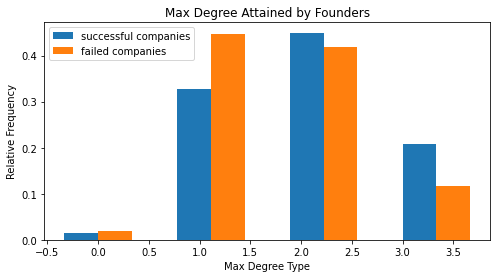

In [60]:
import matplotlib.pylab as plt
from scipy import stats


df = features_and_success_df
max_degree_type_succeeded = df[df["has_succeeded"] == 1]["founders_max_degree_type_ordinal"]
max_degree_type_failed = df[df["has_succeeded"] == 0]["founders_max_degree_type_ordinal"]
val = [max_degree_type_succeeded.dropna().values, max_degree_type_failed.dropna()]

plt.figure(figsize=(8, 4))


ax = plt.subplot(111)
width = 0.3
res_freq = stats.relfreq(val[0])
x1 = res_freq.lowerlimit + np.linspace(0, res_freq.binsize*res_freq.frequency.size, res_freq.frequency.size)
ax.bar(x1, res_freq.frequency, width=res_freq.binsize)

res_freq = stats.relfreq(val[1])
x2 = res_freq.lowerlimit + np.linspace(0, res_freq.binsize*res_freq.frequency.size, res_freq.frequency.size)
ax.bar(x2+res_freq.binsize, res_freq.frequency, width=res_freq.binsize)

ax.set_xlabel('Max Degree Type')
ax.set_ylabel('Relative Frequency')
ax.set_title('Max Degree Attained by Founders')
ax.legend(["successful companies", "failed companies"], loc="upper left")

plt.show()